Stages:

A. Fetch and process data

B. Define initial model

C-1. Tuning hyperparameters 1

D-1. Selecting features 1

C-2. Tuning hyperparameters 2

D-2. Selecting features 2

E. Training final model and saving output

A. Fetch and process data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import TransformedTargetRegressor
from sklearn.base import clone
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

from  helper_functions_training import *

In [38]:
#load training data
raw_train_df = pd.read_csv('train_house_final.csv')

#Numerically encode categorical features
train_df_encode = encode_categories(raw_train_df)

#Split train dataset into X (features) and y (targets)
X_train_all = train_df_encode.drop('Price', axis=1)
y_train_all = train_df_encode['Price']

#Split train data into train and validate subsets
df_train, df_validate = train_test_split(train_df_encode, random_state=89)

#split train and validate subsets into X and y
X_train = df_train.drop('Price', axis=1)
y_train = df_train['Price']
X_validate = df_validate.drop('Price', axis=1)
y_validate = df_validate['Price']

X_train_all.shape, y_train_all.shape, X_train.shape, y_train.shape, X_validate.shape, y_validate.shape

((2832894, 19), (2832894,), (2124670, 19), (2124670,), (708224, 19), (708224,))

In [39]:
#Manageable subset for feature and hyperparameter tuning of model
head_count = 50000
X_train_subset = X_train.head(head_count)
y_train_subset = y_train.head(head_count)

B. Define initial model

In [5]:
#Defining pipeline for random forest model

#Pipeline for X
X_pipeline = Pipeline([('log_transform', LogTransformer()),
                       ('scaler', StandardScaler()),
                       ('regressor', RandomForestRegressor(random_state=89))])
#Pipeline including log of y
ramdom_forest_model_pipeline = TransformedTargetRegressor(regressor = X_pipeline,
                                             transformer = ConditionalLogTransformer())

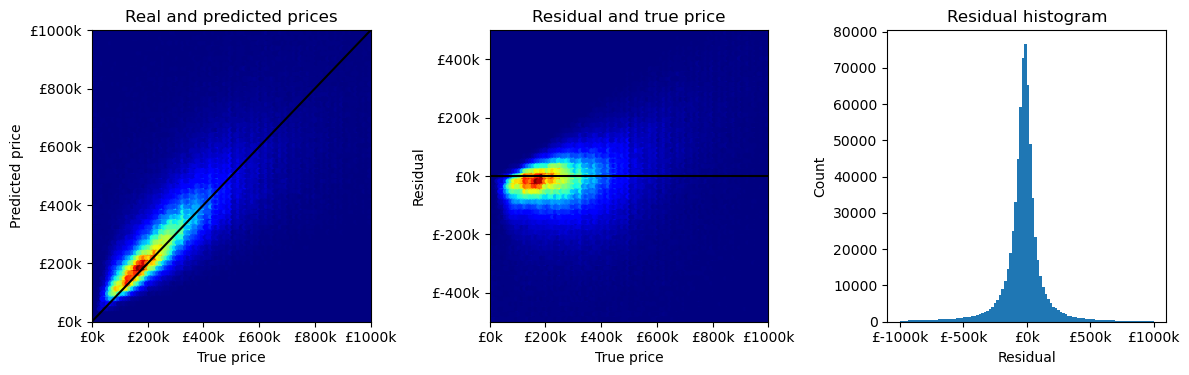

R² = 0.002


In [9]:
#Initial model fit
head_count = 50000

model_1 = clone(ramdom_forest_model_pipeline)
model_1.fit(X_train.head(head_count),y_train.head(head_count) )
y_validate_predict = model_1.predict(X_validate)
assess_predict(y_validate, y_validate_predict)

C-1. Tuning hyperparameters 1

In [ ]:
param_grid = {'regressor__regressor__n_estimators':[100,200,500],
                'regressor__regressor__max_depth':[20,30,None],
                'regressor__regressor__min_samples_split':[5,10,20],
                'regressor__regressor__min_samples_leaf':[2,4,8],
                'regressor__regressor__max_features':['sqrt','log2',0.3],
                'regressor__log_transform__log_income': [True, False],
                'regressor__log_transform__log_listings': [True, False],
                'transformer__log_target': [True, False]}

# randomised search
from sklearn.model_selection import RandomizedSearchCV
random_search = RandomizedSearchCV(
    model_1,
    param_grid,
    cv=3,
    scoring='r2',
    n_iter=200, #About 10% of sample space
    random_state=89,
    n_jobs=-1)

random_search.fit(X_train_subset, y_train_subset)

In [16]:
print("Best parameters:", random_search.best_params_)
#Optimal hyperparameters when all features used

Best parameters: {'transformer__log_target': False, 'regressor__regressor__n_estimators': 500, 'regressor__regressor__min_samples_split': 20, 'regressor__regressor__min_samples_leaf': 8, 'regressor__regressor__max_features': 0.3, 'regressor__regressor__max_depth': 20, 'regressor__log_transform__log_listings': True, 'regressor__log_transform__log_income': False}


D-1. Selecting features 1

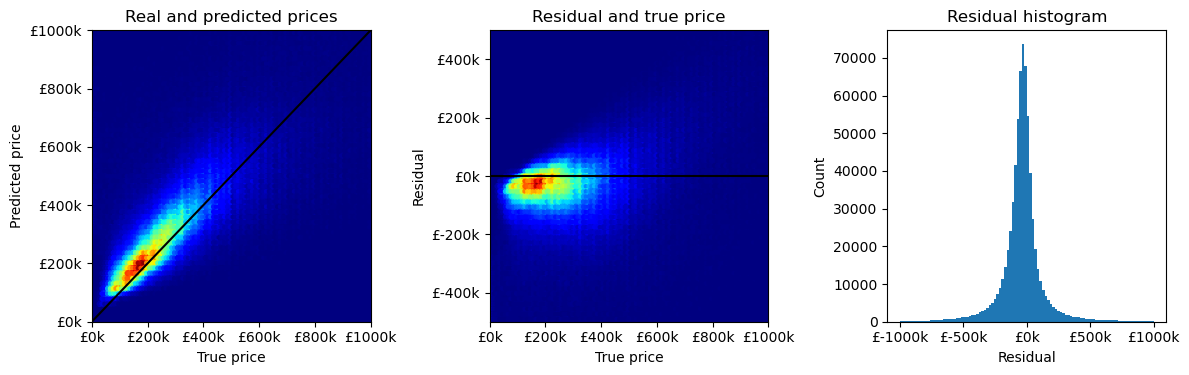

R² = 0.097


In [8]:
#Initial model fit
head_count = 50000

model_2 = clone(ramdom_forest_model_pipeline)
model_2.set_params(
    regressor__regressor__n_estimators=500,
    regressor__regressor__min_samples_split=20,
    regressor__regressor__min_samples_leaf=8,
    regressor__regressor__max_features=0.3,
    regressor__regressor__max_depth=20,
    regressor__log_transform__log_listings=True,
)

model_2.fit(X_train.head(head_count),y_train.head(head_count))
y_validate_predict = model_2.predict(X_validate)
assess_predict(y_validate, y_validate_predict)

In [18]:
feature_importance = feature_importance_test(model_2, X_train_subset, y_train_subset, X_validate, y_validate)

r2 = 0.097, change = 0.000
features: ['New' 'Tenure' 'latitude' 'longitude' 'gender_ratio' 'child_ratio'
 'elderly_ratio' 'commute_distance' 'Income' 'Eng_Wal' 'London_distance'
 'listings_per_capita' 'days_since_first' 'sine_day' 'cosine_day' 'Type_D'
 'Type_F' 'Type_S' 'Type_T']
least important feature: Eng_Wal

r2 = 0.096, change = 0.000
features: ['New' 'Tenure' 'latitude' 'longitude' 'gender_ratio' 'child_ratio'
 'elderly_ratio' 'commute_distance' 'Income' 'London_distance'
 'listings_per_capita' 'days_since_first' 'sine_day' 'cosine_day' 'Type_D'
 'Type_F' 'Type_S' 'Type_T']
least important feature: New

r2 = 0.097, change = -0.000
features: ['Tenure' 'latitude' 'longitude' 'gender_ratio' 'child_ratio'
 'elderly_ratio' 'commute_distance' 'Income' 'London_distance'
 'listings_per_capita' 'days_since_first' 'sine_day' 'cosine_day' 'Type_D'
 'Type_F' 'Type_S' 'Type_T']
least important feature: sine_day

r2 = 0.096, change = 0.001
features: ['Tenure' 'latitude' 'longitude' 'gender_ra

KeyError: 'listings_per_capita'

In [9]:
#Crashed because no clause to ignore log of features if trying to transform  but they are not present. Patched and running from where it crashed
#There won't be a complete dataframe at the end, but all the important data is printed to the console
feature_subset = ['Tenure','latitude','longitude','commute_distance','Income','London_distance','listings_per_capita']
feature_importance = feature_importance_test(model_2, X_train_subset[feature_subset], y_train_subset, X_validate[feature_subset], y_validate)

r2 = 0.075, change = 0.000
features: ['Tenure' 'latitude' 'longitude' 'commute_distance' 'Income'
 'London_distance' 'listings_per_capita']
least important feature: listings_per_capita

r2 = 0.073, change = 0.002
features: ['Tenure' 'latitude' 'longitude' 'commute_distance' 'Income'
 'London_distance']
least important feature: longitude

r2 = 0.073, change = 0.000
features: ['Tenure' 'latitude' 'commute_distance' 'Income' 'London_distance']
least important feature: latitude

r2 = 0.069, change = 0.003
features: ['Tenure' 'commute_distance' 'Income' 'London_distance']
least important feature: Income

r2 = 0.059, change = 0.010
features: ['Tenure' 'commute_distance' 'London_distance']
least important feature: commute_distance

r2 = 0.022, change = 0.037
features: ['Tenure' 'London_distance']
least important feature: Tenure

r2 = -0.005, change = 0.027
features: ['London_distance']
least important feature: London_distance



C-2. Tuning hyperparameters 2

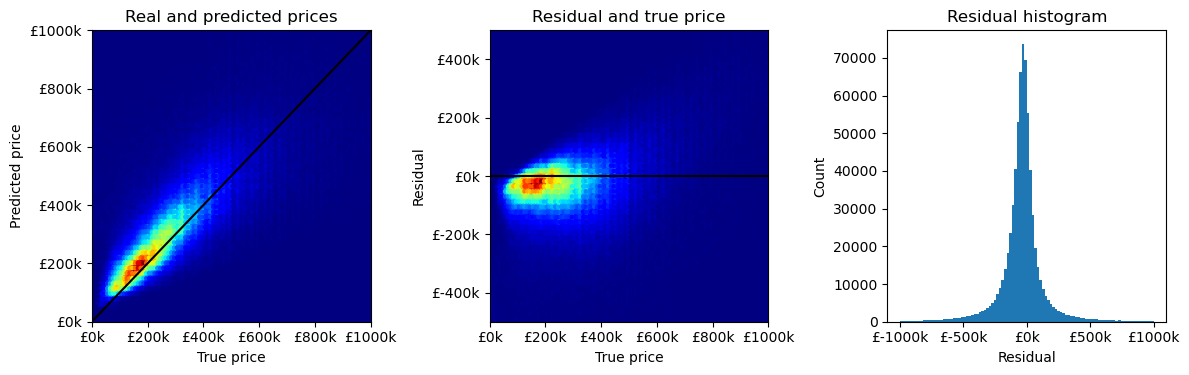

R² = 0.097


In [14]:
important_feautres = ['Tenure','latitude','longitude','gender_ratio','child_ratio',
                      'elderly_ratio','commute_distance','Income','London_distance',
                      'listings_per_capita','days_since_first','Type_D','Type_F','Type_S',
                      'Type_T']

model_3 = clone(ramdom_forest_model_pipeline)
model_3.set_params(
    regressor__regressor__n_estimators=500,
    regressor__regressor__min_samples_split=20,
    regressor__regressor__min_samples_leaf=8,
    regressor__regressor__max_features=0.3,
    regressor__regressor__max_depth=20,
    regressor__log_transform__log_listings=True,
)

model_3.fit(X_train_subset[important_feautres], y_train_subset)
y_validate_predict = model_3.predict(X_validate[important_feautres])
assess_predict(y_validate, y_validate_predict)

In [8]:
param_grid_2 = {'regressor__regressor__max_depth':[20,30,None],
                'regressor__regressor__min_samples_split':[5,10,20],
                'regressor__regressor__min_samples_leaf':[2,4,8],
                'regressor__regressor__max_features':['sqrt','log2',0.3],
                'regressor__log_transform__log_income': [True, False],
                'regressor__log_transform__log_listings': [True, False],
                'transformer__log_target': [True, False]}

# randomised search
random_search = RandomizedSearchCV(
    model_3,
    param_grid_2,
    cv=3,
    scoring='r2',
    n_iter=100, #About 10% of sample space
    random_state=89,
    n_jobs=-1)

random_search.fit(X_train_subset, y_train_subset)

,"estimator estimator: estimator objectAn object of that type is instantiated for each grid point.This is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",TransformedTa...Transformer())
,"param_distributions param_distributions: dict or list of dictsDictionary with parameters names (`str`) as keys and distributionsor lists of parameters to try. Distributions must provide a ``rvs``method for sampling (such as those from scipy.stats.distributions).If a list is given, it is sampled uniformly.If a list of dicts is given, first a dict is sampled uniformly, andthen a parameter is sampled using that dict as above.","{'regressor__log_transform__log_income': [True, False], 'regressor__log_transform__log_listings': [True, False], 'regressor__regressor__max_depth': [20, 30, ...], 'regressor__regressor__max_features': ['sqrt', 'log2', ...], ...}"
,"n_iter n_iter: int, default=10Number of parameter settings that are sampled. n_iter tradesoff runtime vs quality of the solution.",100
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.If None, the estimator's score method is used.",'r2'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given the ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``RandomizedSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across cal

In [10]:
print("Best parameters:", random_search.best_params_)
#Optimal hyperparameters when all features used
#Slightly different to previous hyperparameters

Best parameters: {'transformer__log_target': False, 'regressor__regressor__min_samples_split': 5, 'regressor__regressor__min_samples_leaf': 8, 'regressor__regressor__max_features': 0.3, 'regressor__regressor__max_depth': 30, 'regressor__log_transform__log_listings': False, 'regressor__log_transform__log_income': True}


In [19]:
#Now tuning n estimators to find ceiling with updated other hyperparameters
model_4 = clone(model_3)
model_4.set_params(
    regressor__regressor__min_samples_split=5,
    regressor__regressor__min_samples_leaf=8,
    regressor__regressor__max_features=0.3,
    regressor__regressor__max_depth=30,
    regressor__log_transform__log_income=True,
)

param_grid_4 = {'regressor__regressor__n_estimators':[200,400,600,800,1000,1500]}

grid_search = GridSearchCV(
    model_4,
    param_grid_4,
    cv=3,
    scoring='r2',
    n_jobs=-1)

grid_search.fit(X_train_subset, y_train_subset)

,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",TransformedTa...Transformer())
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'regressor__regressor__n_estimators': [200, 400, ...]}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'r2'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",3
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for each fold and parameter candidate is displayed;- >2 : the score is also displayed;- >3 : th

In [25]:
# Get the mean R² score for each parameter
r2_scores = grid_search.cv_results_['mean_test_score']
params = grid_search.cv_results_['params']
for param, score in zip(params, r2_scores):
    print(f"Parameters: {param}: R2 Score={score:.3f}")
#No significant (<0.001) increase in r2 beyond 600 estimators. So will use that value. Updated from 500, so small change. Will not retune other hyperparameters and will continue to reselect features

Parameters: {'regressor__regressor__n_estimators': 200}: R2 Score=0.139
Parameters: {'regressor__regressor__n_estimators': 400}: R2 Score=0.141
Parameters: {'regressor__regressor__n_estimators': 600}: R2 Score=0.142
Parameters: {'regressor__regressor__n_estimators': 800}: R2 Score=0.142
Parameters: {'regressor__regressor__n_estimators': 1000}: R2 Score=0.142
Parameters: {'regressor__regressor__n_estimators': 1500}: R2 Score=0.142


D-2. Selecting features 2

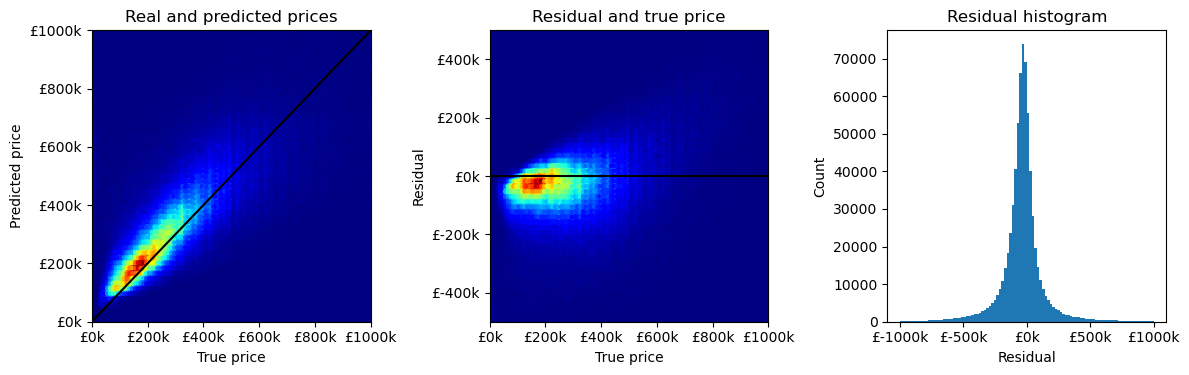

R² = 0.097


In [28]:
model_5 = clone(ramdom_forest_model_pipeline)
model_5.set_params(
    regressor__regressor__n_estimators=600,
    regressor__regressor__min_samples_split=20,
    regressor__regressor__min_samples_leaf=8,
    regressor__regressor__max_features=0.3,
    regressor__regressor__max_depth=20,
    regressor__log_transform__log_listings=True,
)

model_5.fit(X_train_subset[important_feautres], y_train_subset)
y_validate_predict = model_5.predict(X_validate[important_feautres])
assess_predict(y_validate, y_validate_predict)

In [29]:
feature_importance = feature_importance_test(model_5, X_train_subset, y_train_subset, X_validate, y_validate)

r2 = 0.096, change = 0.000
features: ['New' 'Tenure' 'latitude' 'longitude' 'gender_ratio' 'child_ratio'
 'elderly_ratio' 'commute_distance' 'Income' 'Eng_Wal' 'London_distance'
 'listings_per_capita' 'days_since_first' 'sine_day' 'cosine_day' 'Type_D'
 'Type_F' 'Type_S' 'Type_T']
least important feature: Eng_Wal

r2 = 0.096, change = 0.000
features: ['New' 'Tenure' 'latitude' 'longitude' 'gender_ratio' 'child_ratio'
 'elderly_ratio' 'commute_distance' 'Income' 'London_distance'
 'listings_per_capita' 'days_since_first' 'sine_day' 'cosine_day' 'Type_D'
 'Type_F' 'Type_S' 'Type_T']
least important feature: New

r2 = 0.096, change = -0.000
features: ['Tenure' 'latitude' 'longitude' 'gender_ratio' 'child_ratio'
 'elderly_ratio' 'commute_distance' 'Income' 'London_distance'
 'listings_per_capita' 'days_since_first' 'sine_day' 'cosine_day' 'Type_D'
 'Type_F' 'Type_S' 'Type_T']
least important feature: sine_day

r2 = 0.096, change = 0.001
features: ['Tenure' 'latitude' 'longitude' 'gender_ra

In [32]:
feature_importance
#Exact same features are significant in this model as the previous iteration
#Convergence reached

,least_important_feature,r2,r2_change
0,Eng_Wal,0.096376,0.000000
1,New,0.096343,0.000033
2,sine_day,0.096366,-0.000023
3,cosine_day,0.095630,0.000736
4,Type_D,0.096503,-0.000873
5,days_since_first,0.093915,0.002589
6,Type_S,0.093714,0.000201
7,gender_ratio,0.087698,0.006016
8,Type_T,0.087901,-0.000203
9,child_ratio,0.082010,0.005891


E. Training final model and saving output

In [44]:
#Prepare final model

#Optimised hyperparameters
forest_model_final = clone(ramdom_forest_model_pipeline).set_params(
    regressor__regressor__n_estimators=600,
    regressor__regressor__min_samples_split=20,
    regressor__regressor__min_samples_leaf=8,
    regressor__regressor__max_features=0.3,
    regressor__regressor__max_depth=20,
    regressor__log_transform__log_listings=True,
)

#Optimised features
important_feautures_final = [
    'Tenure',
    'latitude',
    'longitude',
    'gender_ratio',
    'child_ratio',
    'elderly_ratio',
    'commute_distance',
    'Income',
    'London_distance',
    'listings_per_capita',
    'days_since_first',
    'Type_D',
    'Type_F',
    'Type_S',
    'Type_T'
]

In [45]:
forest_model_final.fit(X_train_all[important_feautures_final], y_train_all)

,"regressor regressor: object, default=NoneRegressor object such as derived from:class:`~sklearn.base.RegressorMixin`. This regressor willautomatically be cloned each time prior to fitting. If `regressor isNone`, :class:`~sklearn.linear_model.LinearRegression` is created and used.",Pipeline(step...m_state=89))])
,"transformer transformer: object, default=NoneEstimator object such as derived from:class:`~sklearn.base.TransformerMixin`. Cannot be set at the same timeas `func` and `inverse_func`. If `transformer is None` as well as`func` and `inverse_func`, the transformer will be an identitytransformer. Note that the transformer will be cloned during fitting.Also, the transformer is restricting `y` to be a numpy array.",ConditionalLogTransformer()
,"func func: function, default=NoneFunction to apply to `y` before passing to :meth:`fit`. Cannot be setat the same time as `transformer`. If `func is None`, the function used will bethe identity function. If `func` is set, `inverse_func` also needs to beprovided. The function needs to return a 2-dimensional array.",None
,"inverse_func inverse_func: function, default=NoneFunction to apply to the prediction of the regressor. Cannot be set atthe same time as `transformer`. The inverse function is used to returnpredictions to the same space of the original training labels. If`inverse_func` is set, `func` also needs to be provided. The inversefunction needs to return a 2-dimensional array.",None
,"check_inverse check_inverse: bool, default=TrueWhether to check that `transform` followed by `inverse_transform`or `func` followed by `inverse_func` leads to the original targets.",True
,log_income,False
,log_listings,True
,"copy copy: bool, default=TrueIf False, try to avoid a copy and do inplace scaling instead.This is not guaranteed to always work inplace; e.g. if the data isnot a NumPy array or scipy.sparse CSR matrix, a copy may still bereturned.",True
,"with_mean with_mean: bool, default=TrueIf True, center the data before scaling.This does not work (and will raise an exception) when attempted onsparse matrices, because centering them entails building a densematrix which in common use cases is likely to be too large to fit inmemory.",True
,"with_std with_std: bool, default=TrueIf True, scale the data to unit variance (or equivalently,unit standard deviation).",True
,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",600


In [46]:
#Fetch test data
raw_test_df = pd.read_csv('test_house_final.csv')

#Numerically encode categorical features
test_df_encode = encode_categories(raw_test_df)

#Split train dataset into X (features) and y (targets)
X_test = test_df_encode.drop('Price', axis=1)
y_test = test_df_encode['Price']

X_test.shape, y_test.shape

((523267, 19), (523267,))

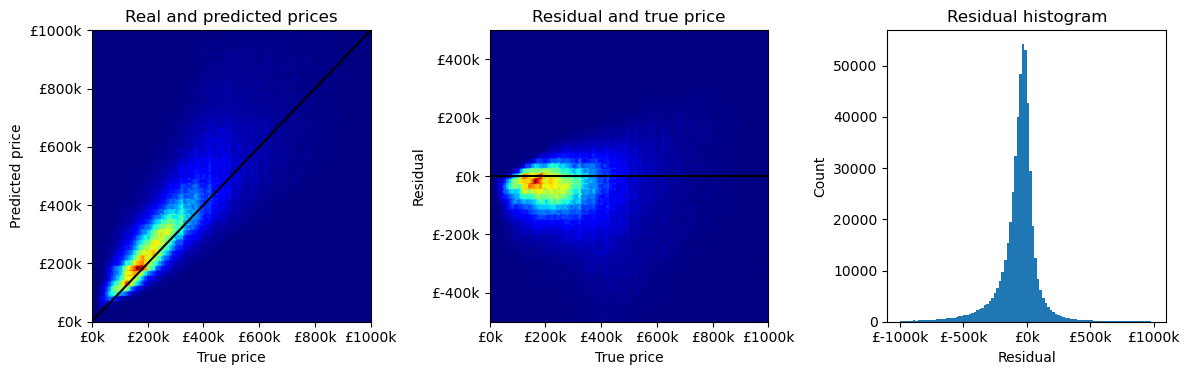

R² = 0.086


In [47]:
#Predict prices of test data
y_test_pred_final = forest_model_final.predict(X_test[important_feautures_final])

#Check fit
assess_predict(y_test, y_test_pred_final)

In [52]:
#Save final fit to csv
final_fit = pd.DataFrame({
    'True_Price': y_test,
    'RForest_Prediction': y_test_pred_final
})
final_fit.to_csv('test_results\\rforest_model.csv', index_label='Index', float_format='%.2f')